In [198]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dfply import *

In [199]:
# 환경설정
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic'

In [89]:
# 데이터 불러오기
benz = pd.read_excel('data/carlist_benz_20200417.xlsx')

In [535]:
# 데이터 가공
benz_mod = benz >> \
    drop(X.link) >> \
    mask(~X.prc.str.contains('승계') | ~X.prc.str.contains('홈서비스')) >> \
    mask(~X.name2.str.contains('기타') | ~X.name2.str.contains('190-클래스') | ~X.name2.str.contains('스프린터')) >> \
    mask(~X['loc'].isna()) >> \
    mutate(yer_mod=("20"+X.yer.str.slice(0,2)).astype(int)) >> \
    mutate(mon_mod=X.yer.str.slice(3,5).astype(int)) >> \
    mutate(earned_months=12*(2020-X.yer_mod)+(4-X.mon_mod)+0.5) >> \
    mask((X.yer_mod>=2013) & (X.yer_mod<=2020)) >> \
    mutate(prc_mod=X.prc.str.replace('만원', '').str.replace(',', '').astype(int)) >> \
    mutate(km_mod=X.km.str.replace('km', '').str.replace(',', '').astype(int)) >> \
    mask(~X.fue.str.contains('전기')) >> \
    mask(X.prc_mod < 20000) >> \
    drop(X.yer, X.km, X.mon_mod, X.prc, X['name1'], X['name4']) >> \
    mutate(ins=if_else(X.ins.isna(), "N", "Y")) >> \
    mutate(ass=if_else(X.ass.isna(), "N", "Y")) >> \
    rename(name = X['name2'], name_sub=X['name3'], yer=X.yer_mod, prc=X.prc_mod, km=X.km_mod) >> \
    mutate(km_per_yer=X.km/X.earned_months*12) >> \
    mutate(log_prc=X.prc.apply(lambda x: np.log(x)))
    
benz_mod = benz_mod.reset_index(drop=True)
benz_mod.head()

,name,name_sub,fue,loc,ins,ass,yer,earned_months,prc,km,km_per_yer,log_prc
0,E-클래스 W213,E220d 4MATIC 아방가르드,디젤,경기,N,N,2016,42.5,4850,37500,10588.235294,8.486734
1,CLA-클래스 C117,CLA45 AMG 4MATIC,가솔린,경기,N,N,2015,55.5,3500,47000,10162.162162,8.160518
2,C-클래스 W204,C220 CDI 아방가르드,디젤,경기,Y,Y,2013,81.5,1350,124300,18301.840491,7.207860
3,S-클래스 W222,S63 AMG 4MATIC+ 퍼포먼스 에디션,가솔린,서울,Y,N,2018,21.5,17900,28000,15627.906977,9.792556
4,E-클래스 W212,E300 엘레강스,가솔린,서울,Y,Y,2013,77.5,2500,27858,4313.496774,7.824046


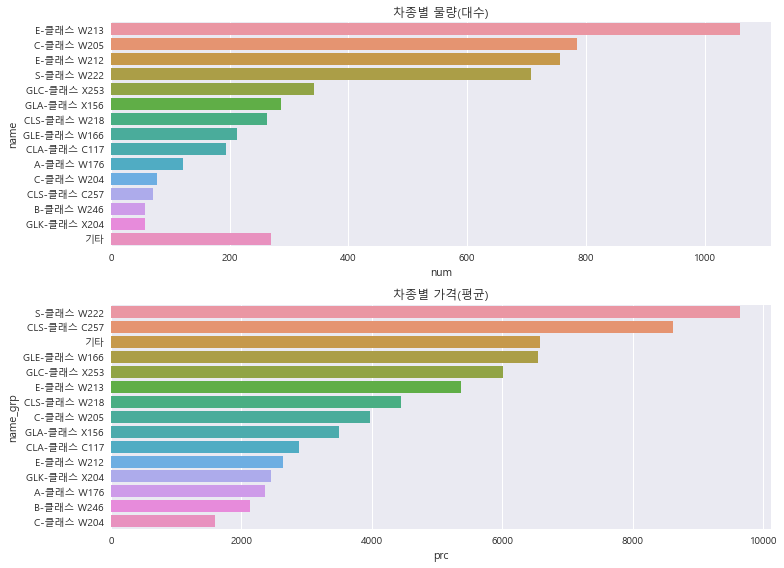

In [536]:
fig, axes = plt.subplots(2, 1, figsize=(11,8))

# 차종별 물량
cnt_by_name = benz_mod.groupby('name').size().sort_values(ascending=False)
cnt_etc = cnt_by_name[14:].sum()
cnt_by_name = cnt_by_name[:14]
cnt_by_name['기타'] = cnt_etc
cnt_by_name = cnt_by_name.reset_index(name='num')
sns.barplot(y='name', x='num', data=cnt_by_name, ax=axes[0])
axes[0].set_title('차종별 물량(대수)')
benz_mod['name_grp'] = benz_mod.name.copy()
benz_mod.loc[~benz_mod.name_grp.isin(cnt_by_name.name[:-1]), 'name_grp'] = '기타'

# 차종별 가격(평균)
prc_by_name = benz_mod.groupby('name_grp')['prc'].mean().sort_values(ascending=False)
prc_by_name = prc_by_name.reset_index(name='prc')
sns.barplot(y='name_grp', x='prc', data=prc_by_name, ax=axes[1])
axes[1].set_title('차종별 가격(평균)')

plt.tight_layout()
plt.show()

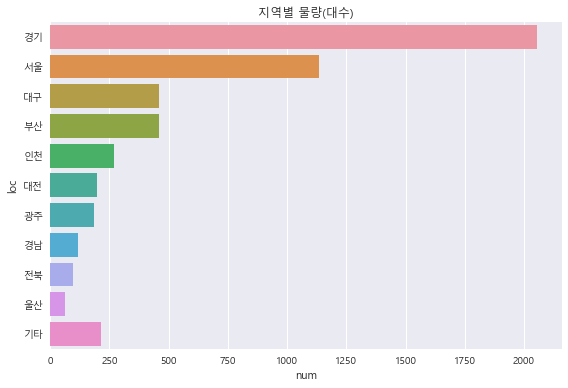

In [537]:
# 지역별 물량
cnt_by_loc = benz_mod.groupby('loc').size().sort_values(ascending=False)
cnt_etc = cnt_by_loc[10:].sum()
cnt_by_loc = cnt_by_loc[:10]
cnt_by_loc['기타'] = cnt_etc
cnt_by_loc = cnt_by_loc.reset_index(name='num')
sns.barplot(y='loc', x='num', data=cnt_by_loc)
plt.title('지역별 물량(대수)')
plt.tight_layout()
plt.show()

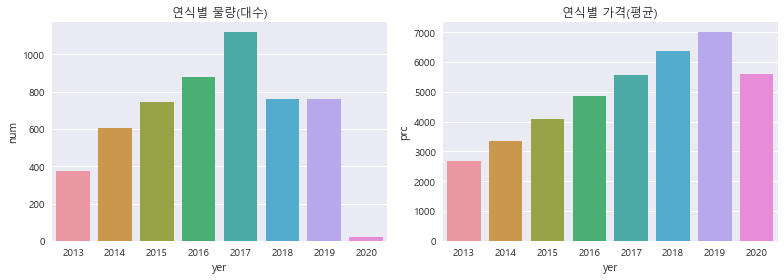

In [538]:
fig, axes = plt.subplots(1, 2, figsize=(11,4))

# 연식별 물량
cnt_by_yer = benz_mod.groupby('yer').size()
cnt_by_yer = cnt_by_yer.reset_index(name='num')
sns.barplot(x='yer', y='num', data=cnt_by_yer, ax=axes[0])
axes[0].set_title('연식별 물량(대수)')

# 연식별 가격(평균)
prc_by_yer = benz_mod.groupby('yer')['prc'].mean()
prc_by_yer = prc_by_yer.reset_index(name='prc')
sns.barplot(x='yer', y='prc', data=prc_by_yer, ax=axes[1])
axes[1].set_title('연식별 가격(평균)')

plt.tight_layout()
plt.show()

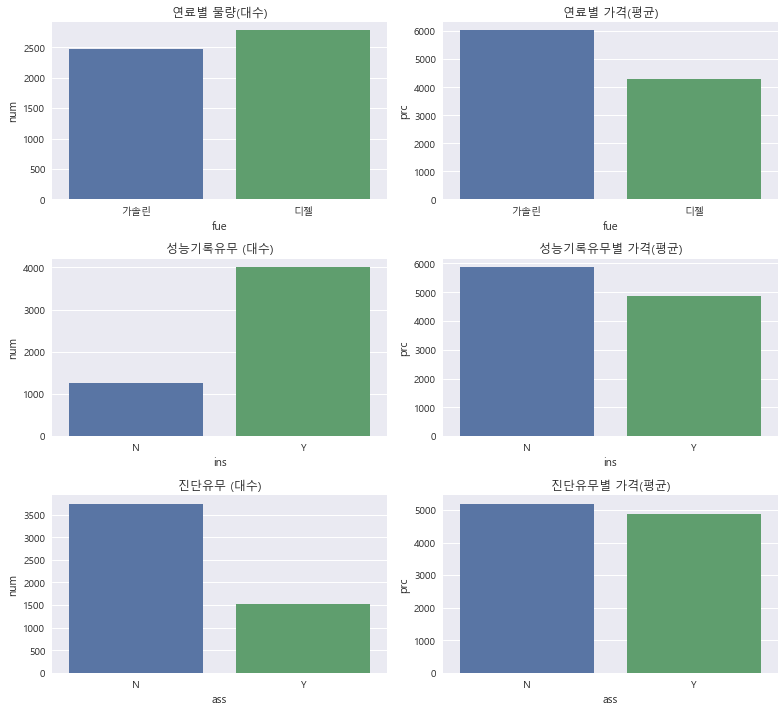

In [539]:
fig, axes = plt.subplots(3, 2, figsize=(11,10))

# 연료별 물량
cnt_by_fue = benz_mod.groupby('fue').size()
cnt_by_fue = cnt_by_fue.reset_index(name='num')
sns.barplot(x='fue', y='num', data=cnt_by_fue, ax=axes[0][0])
axes[0][0].set_title('연료별 물량(대수)')

# 연식별 가격(평균)
prc_by_fue = benz_mod.groupby('fue')['prc'].mean()
prc_by_fue = prc_by_fue.reset_index(name='prc')
sns.barplot(x='fue', y='prc', data=prc_by_fue, ax=axes[0][1])
axes[0][1].set_title('연료별 가격(평균)')

# 성능기록유무(대수)
cnt_by_ins = benz_mod.groupby('ins').size()
cnt_by_ins = cnt_by_ins.reset_index(name='num')
sns.barplot(x='ins', y='num', data=cnt_by_ins, ax=axes[1][0])
axes[1][0].set_title('성능기록유무 (대수)')

# 성능기록유무별 가격(평균)
prc_by_ins = benz_mod.groupby('ins')['prc'].mean()
prc_by_ins = prc_by_ins.reset_index(name='prc')
sns.barplot(x='ins', y='prc', data=prc_by_ins, ax=axes[1][1])
axes[1][1].set_title('성능기록유무별 가격(평균)')

# 진단여부(대수)
cnt_by_ass = benz_mod.groupby('ass').size()
cnt_by_ass = cnt_by_ass.reset_index(name='num')
sns.barplot(x='ass', y='num', data=cnt_by_ass, ax=axes[2][0])
axes[2][0].set_title('진단유무 (대수)')

# 진단여부별 가격(평균)
prc_by_ass = benz_mod.groupby('ass')['prc'].mean()
prc_by_ass = prc_by_ass.reset_index(name='prc')
sns.barplot(x='ass', y='prc', data=prc_by_ass, ax=axes[2][1])
axes[2][1].set_title('진단유무별 가격(평균)')

plt.tight_layout()
plt.show()

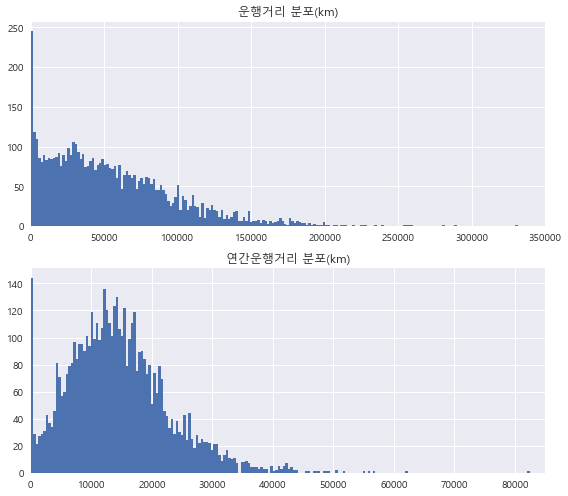

In [540]:
fig, axes = plt.subplots(2, 1, figsize=(8,7))

# 운행거리 분포
axes[0].hist(benz_mod['km'], bins=200)
axes[0].set_title('운행거리 분포(km)')
axes[0].set_xlim(0, 350000)

# 연간 운행거리 분포
axes[1].hist(benz_mod['km_per_yer'], bins=200)
axes[1].set_title('연간운행거리 분포(km)')
axes[1].set_xlim(0, 85000)

plt.tight_layout()
plt.show()

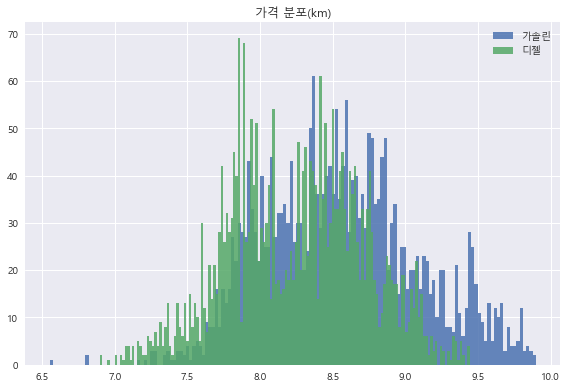

In [545]:
# 가격 분포
grouped = benz_mod.groupby('fue')
for name, df in grouped:
    plt.hist(df['log_prc'], bins=150, label=name, alpha=0.85)

    plt.title('가격 분포(km)')
plt.legend()
plt.tight_layout()
plt.show()

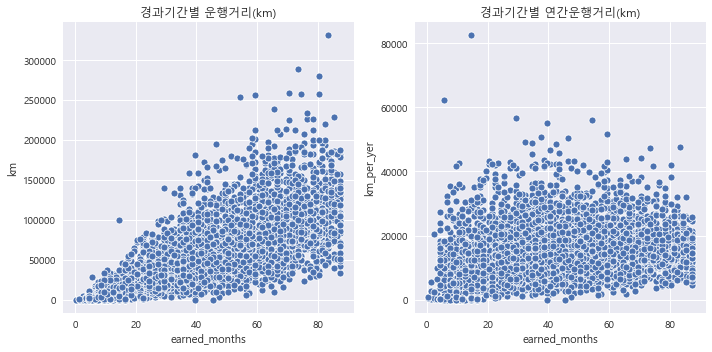

In [543]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.scatterplot(x='earned_months', y='km', data=benz_mod, ax=axes[0])
axes[0].set_title('경과기간별 운행거리(km)')

sns.scatterplot(x='earned_months', y='km_per_yer', data=benz_mod, ax=axes[1])
axes[1].set_title('경과기간별 연간운행거리(km)')

plt.tight_layout()
plt.show()

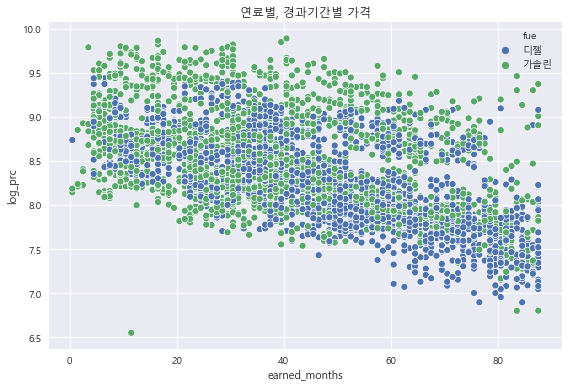

In [546]:
sns.scatterplot(x='earned_months', y='log_prc', hue='fue', data=benz_mod)
plt.title('연료별, 경과기간별 가격')

plt.tight_layout()
plt.show()

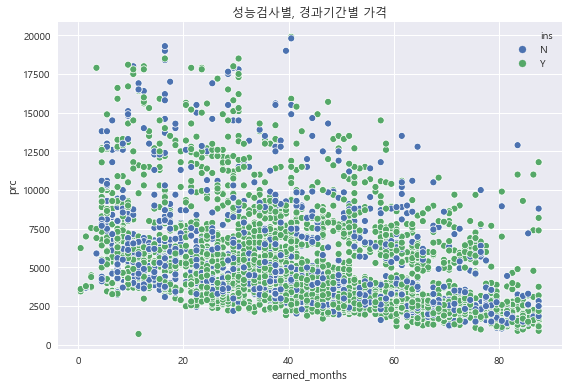

In [549]:
sns.scatterplot(x='earned_months', y='prc', hue='ins', data=benz_mod)
plt.title('성능검사별, 경과기간별 가격')

plt.tight_layout()
plt.show()

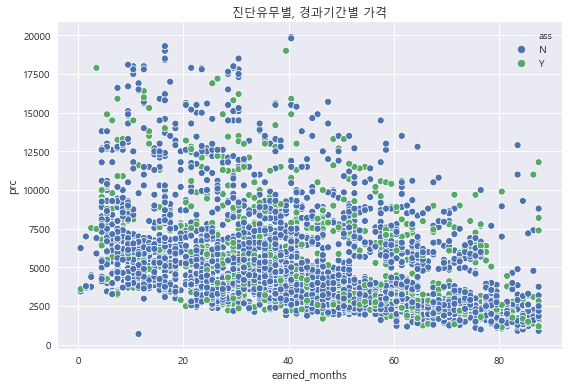

In [550]:
sns.scatterplot(x='earned_months', y='prc', hue='ass', data=benz_mod)
plt.title('진단유무별, 경과기간별 가격')

plt.tight_layout()
plt.show()

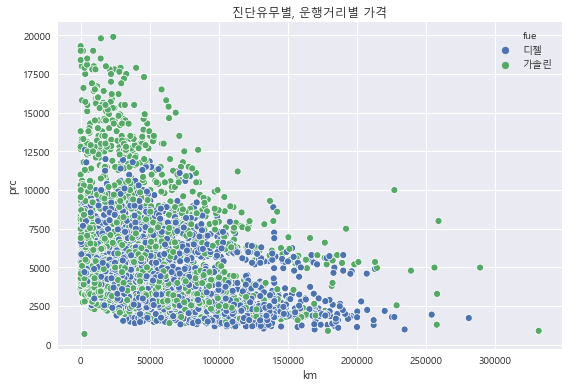

In [554]:
sns.scatterplot(x='km', y='prc', hue='fue', data=benz_mod)
plt.title('진단유무별, 운행거리별 가격')

plt.tight_layout()
plt.show()

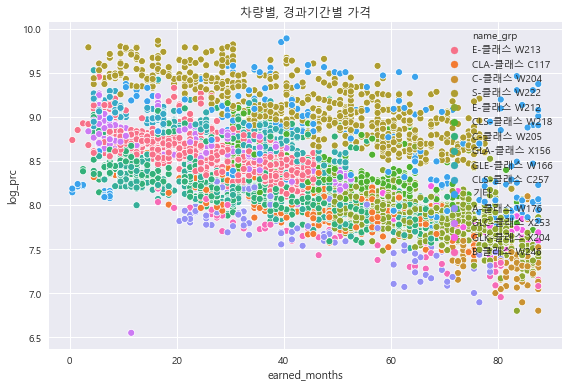

In [556]:
sns.scatterplot(x='earned_months', y='log_prc', hue='name_grp', data=benz_mod)
plt.title('차량별, 경과기간별 가격')

plt.tight_layout()
plt.show()

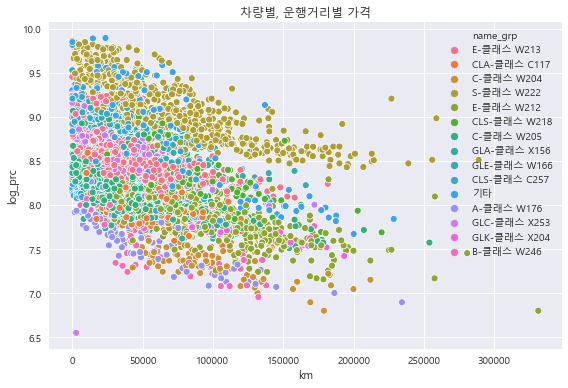

In [555]:
sns.scatterplot(x='km', y='log_prc', hue='name_grp', data=benz_mod)
plt.title('차량별, 운행거리별 가격')

plt.tight_layout()
plt.show()